# 4. Modelo Baseline  
---  
En esta sección se describe la arquitectura de la CNN evaluada como modelo baseline para la clasificación automática de radiografías en las tres clases definidas previamente: **Normal**, **Osteopenia** y **Osteoporosis**.

Como baseline, se eligió **ResNet18**, una red preentrenada con el conjunto de datos **ImageNet**, lo que implica que no es necesario entrenar todos los parámetros desde cero. Esta característica facilita obtener resultados aceptables como punto de partida para la tarea específica.

ResNet18 presenta además una arquitectura más liviana en comparación con redes más profundas como **ResNet34** o **ResNet50**, lo que reduce el costo computacional durante el entrenamiento y la inferencia. En caso de obtener buenos resultados con esta red, se podrá considerar la utilización de arquitecturas más profundas para mejorar el desempeño.

La elección de este modelo se fundamenta en la premisa de que el diagnóstico automatizado en radiología requiere redes capaces de identificar patrones sutiles en imágenes médicas. A diferencia de las imágenes naturales (como las de ImageNet), las imágenes radiológicas presentan:

- Menor variabilidad cromática (frecuentemente en escala de grises),  
- Mayor dependencia de texturas y detalles locales,  
- Diferencias de contraste más sutiles entre estados patológicos.

En particular, la progresiva disminución de la densidad ósea implica cambios leves y localizados, lo que exige modelos que no solo reconozcan formas globales, sino también texturas finas y patrones locales.

Además, debido al tamaño relativamente reducido de los conjuntos de datos en radiología, se recomienda el uso de *transfer learning*, que permite aprovechar modelos entrenados con grandes volúmenes de datos.

La estrategia de *transfer learning* consiste en utilizar modelos preentrenados con conjuntos como **ImageNet**, adaptándolos posteriormente al dominio específico de imágenes de rayos X. Esta técnica permite:

- Reutilizar filtros genéricos aprendidos (como bordes y texturas),  
- Reducir la necesidad de grandes volúmenes de datos médicos,  
- Acelerar la convergencia del entrenamiento,  
- Disminuir el riesgo de sobreajuste en conjuntos limitados.

La metodología seguida fue la siguiente:

1. **Carga del modelo ResNet-18 preentrenado** en ImageNet.  
2. **Congelación de las primeras capas convolucionales**, que actúan como extractor de características genéricas.  
3. **Sustitución de la capa totalmente conectada final** (*fully connected*) para adaptarla a la clasificación en tres clases: Normal, Osteopenia y Osteoporosis.  
4. **Ajuste fino progresivo** (*fine-tuning*), descongelando capas adicionales con una tasa de aprendizaje reducida.

ResNet-18 ofrece un equilibrio adecuado entre profundidad, capacidad de generalización y eficiencia computacional, haciéndolo especialmente apropiado para tareas de clasificación en imágenes médicas con conjuntos de datos limitados.



## *Preparación de datos*
---

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Cargar los tensores guardados
X_train, y_train = torch.load("train_normalizado.pt")
X_val, y_val = torch.load("val_normalizado.pt")
X_test, y_test = torch.load("test_normalizado.pt")

# Crear datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Crear loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=False)

## *ResNet-18* (baseline) 
---

In [2]:
#!pip install lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from lightning import LightningModule

class LitResNet(LightningModule):
    def __init__(self, num_classes=3):
        super().__init__()
        self.save_hyperparameters()
        resnet = resnet18(weights = ResNet18_Weights.DEFAULT)
        for name, param in resnet.named_parameters():
                if "layer4" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
            
        in_features = resnet.fc.in_features
        resnet.fc = nn.Identity()
        
        #self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = nn.Sequential(
            resnet,
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append(loss.item())
        self.val_accuracies.append(acc.item())

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-5)

In [20]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# early stopping si la validación no mejora después de 5 épocas
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min")

# inicializo el modelo
model = LitResNet(num_classes=3)

# setup del trainer
trainer = Trainer(
    max_epochs=40,
    #callbacks=[early_stop],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    enable_model_summary=False,
    logger=False
)

# entreno
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory c:\Users\javier\OneDrive\Documents\Repo\Vision-por-Computadora-II\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\javier\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 39: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s, train_loss=0.406, train_acc=0.500, val_loss=1.220, val_acc=0.715]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s, train_loss=0.406, train_acc=0.500, val_loss=1.220, val_acc=0.715]


In [21]:
model.eval()
all_preds = []

for x, _ in test_loader:
    x = x.to(model.device)
    with torch.no_grad():
        logits = model(x)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu())

all_preds = torch.cat(all_preds)

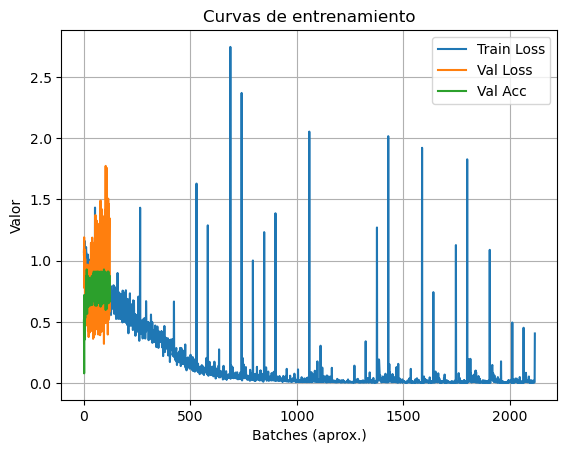

In [22]:
import matplotlib.pyplot as plt

plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Val Loss')
plt.plot(model.val_accuracies, label='Val Acc')
plt.xlabel("Batches (aprox.)")
plt.ylabel("Valor")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import recall_score, f1_score

def compute_enfermo_vs_sano_recall(y_true, y_pred):
    y_true_bin = [0 if x == 'Normal' else 1 for x in y_true]
    y_pred_bin = [0 if x == 'Normal' else 1 for x in y_pred]
    return recall_score(y_true_bin, y_pred_bin)

def compute_enfermedades_f1(y_true, y_pred):
    y_true_sub = [x for x, y in zip(y_true, y_pred) if x != 'Normal']
    y_pred_sub = [y for x, y in zip(y_true, y_pred) if x != 'Normal']
    return f1_score(y_true_sub, y_pred_sub, average='macro') 

def diagnostic_score(y_true, y_pred, alpha=0.7, beta=0.3):
    recall = compute_enfermo_vs_sano_recall(y_true, y_pred)
    f1_enf = compute_enfermedades_f1(y_true, y_pred)
    return alpha * recall + beta * f1_enf

In [23]:
# ==== FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN ====

def plot_training_curves(train_acc, val_acc, train_loss, val_loss, model_name):
    epochs_range = range(len(train_acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.title(f"Accuracy - {model_name}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.title(f"Loss - {model_name}")
    plt.legend()

    plt.show()

def evaluate_and_plot(model, dataloader, clases, model_name, device="cuda"):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases,
                yticklabels=clases)
    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta Real")
    plt.title(f"Matriz de confusión - {model_name}")
    plt.show()

    # Reporte de clasificación
    print(f"Reporte de clasificación para {model_name}:")
    print(classification_report(all_labels, all_preds, target_names=clases))

def test_accuracy(model, dataloader, device="cuda"):
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

def compare_models_accuracy(model_dict, test_loader, device="cuda"):
    results = {}
    for name, model in model_dict.items():
        acc = test_accuracy(model, test_loader, device)
        results[name] = acc

    plt.bar(results.keys(), results.values(), color=["orange", "blue"])
    plt.ylabel("Accuracy en Test")
    plt.title("Comparativa final entre modelos")
    plt.show()

    return results

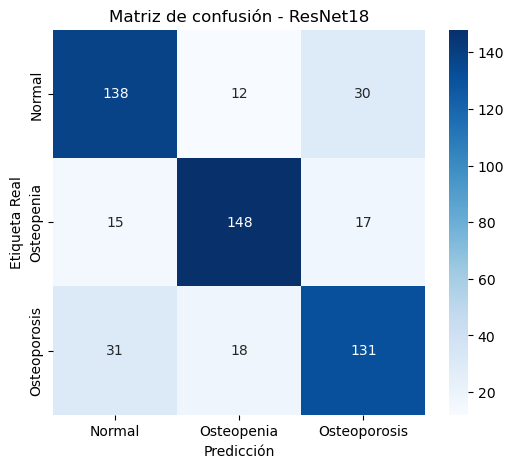

Reporte de clasificación para ResNet18:
              precision    recall  f1-score   support

      Normal       0.75      0.77      0.76       180
  Osteopenia       0.83      0.82      0.83       180
Osteoporosis       0.74      0.73      0.73       180

    accuracy                           0.77       540
   macro avg       0.77      0.77      0.77       540
weighted avg       0.77      0.77      0.77       540



In [24]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

clases = ['Normal', 'Osteopenia', 'Osteoporosis']

# Matriz de confusión + reporte para ResNet
evaluate_and_plot(model, test_loader, clases, "ResNet18")

Como puede observarse, el modelo **ResNet18** alcanza un desempeño global con una **precisión promedio cercana al 78%** en el conjunto de prueba. A partir de la matriz de confusión, se evidencia una buena capacidad para reconocer la clase **Osteopenia**, mientras que la predicción para las clases **Normal** y **Osteoporosis** es levemente menos precisa.

En particular, la clase **Normal** obtuvo **138 predicciones correctas**, aunque fue confundida con **Osteoporosis** en **30 casos** y con **Osteopenia** en **12**. De manera similar, **Osteopenia** se destacó como la clase más confiable, con **148 aciertos**, **15 clasificadas erróneamente como Normal** y **17 como Osteoporosis**. Por su parte, **Osteoporosis** registró **131 predicciones correctas**, mientras que **31 casos** fueron asignados erróneamente a **Normal** y **18 a Osteopenia**. El reporte de clasificación refleja valores de **precisión, recall y F1-score** con un **promedio global del 78%**, confirmando que el modelo ofrece buenos resultados en la predicción de **Osteopenia**, aunque con un rendimiento menor para las otras dos clases.

Este comportamiento es común en el procesamiento de **imágenes médicas**, especialmente cuando las clases presentan **fronteras difusas** o cuando el conjunto de datos es limitado en tamaño y diversidad, lo cual restringe la capacidad del modelo para generalizar.

Estos resultados sugieren que, para mejorar el desempeño, será necesario aumentar la **variabilidad de los datos** mediante técnicas de aumento (**data augmentation**), adoptar **modelos más eficientes y específicos para datasets médicos**, y considerar estrategias de **fine-tuning** junto con funciones de pérdida que penalicen de manera más severa los errores en las clases más complejas.
